# Sanity Rollouts — Random vs Tiny Heuristic (GGEnv v2)

**Goal.** Validate that our environment and observations are sane by comparing:
- a **Random** policy (uniform over {NOOP, FLIP})
- a **Tiny Heuristic** (flip only when near-lane is immediately dangerous and target lane looks safe)

We:
1. (Optionally) run rollouts to generate fresh results.
2. Load `experiments/runs/episodes.csv`.
3. Check basic data integrity.
4. Compare metrics: distance, episode length, death causes.
5. Do a seed-paired comparison (does heuristic consistently beat random?).
6. Summarize findings and next steps.

*Environment:* GGEnv v2, Observation v2 (15-dim), frame_skip=4 by default.


## Step 1 — Setup & locate results

This notebook might be opened from `experiments/notebooks/`, while the rollout results live under `experiments/runs/`.  
Below we:

- set paths relative to the current notebook location,
- try to **auto-find** the results CSV (common names: `episodes.csv` or your earlier `apis.csv`),
- show what we found (or list nearby files to help you point to the right one).


In [8]:
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Paths (notebook opened from experiments/notebooks/) ----
NOTEBOOK_DIR = Path.cwd()
EXP_DIR = NOTEBOOK_DIR.parent              # experiments/
RUNS_DIR = EXP_DIR / "runs"                # experiments/runs/
TRACES_DIR = RUNS_DIR / "traces"           # experiments/runs/traces/

print("CWD (notebook):", NOTEBOOK_DIR)
print("Experiments dir:", EXP_DIR)
print("Runs dir:", RUNS_DIR)
print("Traces dir:", TRACES_DIR)

# ---- Try to locate the results CSV ----
# We support both names to match your comment: "episodes.csv" (default) or "apis.csv"
CANDIDATE_NAMES = ["episodes.csv", "apis.csv"]
CANDIDATE_PATHS = [RUNS_DIR / name for name in CANDIDATE_NAMES] + \
                  [TRACES_DIR / name for name in CANDIDATE_NAMES]

EPISODES_CSV = None
for p in CANDIDATE_PATHS:
    if p.exists():
        EPISODES_CSV = p
        break

if EPISODES_CSV is None:
    print("\n⚠️ Could not auto-find results CSV.")
    print("Listing possible files under runs/ and runs/traces/ to help you locate it:\n")
    for base in [RUNS_DIR, TRACES_DIR]:
        if base.exists():
            print(f"[{base}]")
            for f in sorted(base.glob("*.csv")):
                print("  -", f.name)
            for f in sorted(base.glob("*/*.csv")):
                print("  -", f.relative_to(base))
            print()
    raise FileNotFoundError("Please set EPISODES_CSV manually to the correct path (see listing above).")

print("\n✅ Using results file:", EPISODES_CSV)

# ---- Plot style (optional) ----
plt.rcParams["figure.figsize"] = (8, 4.5)
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False


CWD (notebook): d:\Projects\GravityGuyML\experiments\notebooks
Experiments dir: d:\Projects\GravityGuyML\experiments
Runs dir: d:\Projects\GravityGuyML\experiments\runs
Traces dir: d:\Projects\GravityGuyML\experiments\runs\traces

✅ Using results file: d:\Projects\GravityGuyML\experiments\runs\episodes.csv


## Step 2 — Load results & quick sanity checks

We load the results CSV and normalize a few columns to numeric types.  
Then we:

- preview the first rows,
- confirm key columns exist,
- compute a couple of derived fields we’ll use later:
  - `episode_len_s` = decisions ÷ decision_hz


In [9]:
import pandas as pd
import numpy as np

# --- Load ---
df = pd.read_csv(EPISODES_CSV)

print("Rows loaded:", len(df))
print("Columns:", list(df.columns))

# --- Expected columns (from our rollout script) ---
expected = {
    "env_name","env_version","obs_version",
    "policy_name","seed",
    "frame_skip","sim_fps","decision_hz",
    "episode_len_decisions","return_sum","distance_px",
    "terminated","truncated","death_cause","grounded_ratio"
}
missing = sorted(list(expected - set(df.columns)))
if missing:
    print("\n⚠️ Missing expected columns:", missing)
    print("   -> If you used a different generator, we can adapt; just tell me what’s present.")
else:
    print("\n✅ All expected columns are present.")

# --- Normalize dtypes (robust to strings) ---
to_num = ["frame_skip","sim_fps","decision_hz","episode_len_decisions",
          "return_sum","distance_px","terminated","truncated","grounded_ratio"]
for c in to_num:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

if "seed" in df.columns:
    df["seed"] = pd.to_numeric(df["seed"], errors="coerce").astype("Int64")

# --- Derived metrics ---
if {"episode_len_decisions","decision_hz"}.issubset(df.columns):
    df["episode_len_s"] = df["episode_len_decisions"] / df["decision_hz"]

# --- Quick peek ---
display(df.head(5))

# --- Basic sanity checks ---
print("\nNulls per column:")
display(df.isna().sum().to_frame("nulls"))

if "grounded_ratio" in df.columns:
    oob_gr = df[(df["grounded_ratio"] < 0) | (df["grounded_ratio"] > 1)]
    print("Out-of-bounds grounded_ratio rows:", len(oob_gr))

# Confirm we have at least two policies to compare
if "policy_name" in df.columns:
    print("\nPolicy counts:", df["policy_name"].value_counts().to_dict())


Rows loaded: 40
Columns: ['env_name', 'env_version', 'obs_version', 'policy_name', 'seed', 'frame_skip', 'sim_fps', 'decision_hz', 'episode_len_decisions', 'return_sum', 'distance_px', 'terminated', 'truncated', 'death_cause', 'grounded_ratio']

✅ All expected columns are present.


,env_name,env_version,obs_version,policy_name,seed,frame_skip,sim_fps,decision_hz,episode_len_decisions,return_sum,distance_px,terminated,truncated,death_cause,grounded_ratio,episode_len_s
0,GGEnv,v2,v2,random,101,4,60,15.0,112,110.0,1862.5,1,0,spike,0.161,7.466667
1,GGEnv,v2,v2,random,102,4,60,15.0,222,220.0,3700.0,1,0,spike,0.185,14.800000
2,GGEnv,v2,v2,random,103,4,60,15.0,110,108.0,1825.0,1,0,oob,0.209,7.333333
3,GGEnv,v2,v2,random,104,4,60,15.0,87,85.0,1450.0,1,0,spike,0.207,5.800000
4,GGEnv,v2,v2,random,105,4,60,15.0,191,189.0,3183.3,1,0,oob,0.168,12.733333



Nulls per column:


,nulls
env_name,0
env_version,0
obs_version,0
policy_name,0
seed,0
frame_skip,0
sim_fps,0
decision_hz,0
episode_len_decisions,0
return_sum,0


Out-of-bounds grounded_ratio rows: 0

Policy counts: {'random': 20, 'heuristic': 20}


## Part 3 — Define the comparison cohorts & pairing logic

**What we’re doing.**  
We subset the rollout results into two cohorts by `policy_name`:
- **Random** — uniformly chooses {NOOP, FLIP}
- **Heuristic** — tiny rule that flips only when the near lane looks immediately dangerous and the target lane looks safe

**Why this matters.**  
We want an apples-to-apples comparison. The cleanest way is **seed-paired analysis**:
- Keep only seeds that appear in **both** policies.
- For each such seed, compare core outcomes (distance, episode length).
- This controls for procedural level randomness and isolates policy effect.

**Data structure we’ll create.**
- `rnd`, `heu`: filtered DataFrames for each policy.
- `paired`: index = `seed`, columns:
  - `distance_random`, `distance_heuristic`
  - `len_random` (= episode_len_s), `len_heuristic`
  - `improvement` (= heuristic − random distance)

**What to look for.**  
If the heuristic is sensible, we expect **positive improvements** on most seeds and higher medians overall.


In [11]:
import numpy as np
import pandas as pd

# Normalize policy names to lowercase for robust filtering
if "policy_name" not in df.columns:
    raise ValueError("Expected column 'policy_name' not found.")

df["policy_name"] = df["policy_name"].str.lower()

# Split by policy
rnd = df[df["policy_name"] == "random"].copy()
heu = df[df["policy_name"] == "heuristic"].copy()

print(f"Random rows: {len(rnd)} | Heuristic rows: {len(heu)}")

# Ensure we have episode_len_s (seconds) available
if "episode_len_s" not in df.columns and {"episode_len_decisions","decision_hz"}.issubset(df.columns):
    df["episode_len_s"] = df["episode_len_decisions"] / df["decision_hz"]
    rnd["episode_len_s"] = rnd["episode_len_decisions"] / rnd["decision_hz"]
    heu["episode_len_s"] = heu["episode_len_decisions"] / heu["decision_hz"]

# Pair by seeds available in both cohorts
seeds_both = set(rnd["seed"].dropna().astype(int)) & set(heu["seed"].dropna().astype(int))
print("Seeds present in both cohorts:", len(seeds_both))

r2 = rnd[rnd["seed"].isin(seeds_both)].set_index("seed").sort_index()
h2 = heu[heu["seed"].isin(seeds_both)].set_index("seed").sort_index()

# Build paired table
paired = pd.DataFrame({
    "distance_random": r2["distance_px"],
    "distance_heuristic": h2["distance_px"],
    "len_random": r2["episode_len_s"],
    "len_heuristic": h2["episode_len_s"],
})
paired["improvement"] = paired["distance_heuristic"] - paired["distance_random"]

print("\nPaired preview:")
display(paired.head(10))

print("\nQuick stats (paired seeds only):")
print(paired[["distance_random","distance_heuristic","len_random","len_heuristic","improvement"]].describe())


Random rows: 20 | Heuristic rows: 20
Seeds present in both cohorts: 20

Paired preview:


,distance_random,distance_heuristic,len_random,len_heuristic,improvement
seed,,,,,
101,1862.5,2108.3,7.466667,8.466667,245.8
102,3700.0,4112.5,14.800000,16.466667,412.5
103,1825.0,3291.7,7.333333,13.200000,1466.7
104,1450.0,1458.3,5.800000,5.866667,8.3
105,3183.3,3195.8,12.733333,12.800000,12.5
106,1641.7,2395.8,6.600000,9.600000,754.1
107,2675.0,2808.3,10.733333,11.266667,133.3
108,1729.2,1533.3,6.933333,6.133333,-195.9
109,1600.0,1575.0,6.400000,6.333333,-25.0



Quick stats (paired seeds only):
       distance_random  distance_heuristic  len_random  len_heuristic  \
count        20.000000           20.000000   20.000000      20.000000   
mean       2168.955000         3084.150000    8.686667      12.360000   
std         802.074672         1334.445485    3.204390       5.328524   
min        1450.000000         1458.300000    5.800000       5.866667   
25%        1631.275000         2028.100000    6.550000       8.150000   
50%        1860.400000         2900.000000    7.466667      11.633333   
75%        2431.250000         4204.175000    9.733333      16.833333   
max        4383.300000         5395.800000   17.533333      21.600000   

       improvement  
count    20.000000  
mean    915.195000  
std    1151.029349  
min    -195.900000  
25%      75.050000  
50%     410.400000  
75%    1422.975000  
max    3483.300000  


## Part 4 — Core outcome comparison (distance & episode length)

**What we’re comparing.**
- **Distance (px):** how far the agent survives while the world scrolls.
- **Episode length (s):** decisions ÷ decision rate — equivalent to survival time.

**Why these metrics.**
- They’re independent of reward shaping and directly reflect survivability.
- They’re easy to interpret and compare across policies and seeds.

**Visuals we’ll draw.**
1. **Boxplots** of distance and episode length by policy (all episodes).
2. **Seed-paired line plot** to see per-seed improvements.
3. **Histogram of improvements** (heuristic − random distance) to see the distribution of gains.

**What to look for.**
- The heuristic’s boxes should be **higher** than random’s.
- In the paired lines, the heuristic line should sit **above** the random line most of the time.
- The improvement histogram should be skewed **positive**.


C:\Users\Mbaka\AppData\Local\Temp\ipykernel_7480\2671747164.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([a, b], labels=labels, showfliers=False)
C:\Users\Mbaka\AppData\Local\Temp\ipykernel_7480\2671747164.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([a, b], labels=labels, showfliers=False)


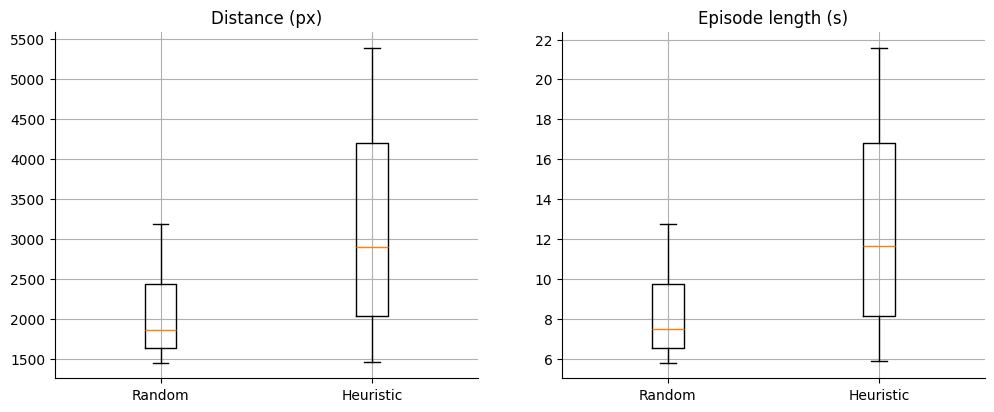

Medians (all rows):
  Random   distance: 1860.4
  Heuristic distance: 2900.0
  Random   length(s): 7.466666666666667
  Heuristic length(s): 11.633333333333333


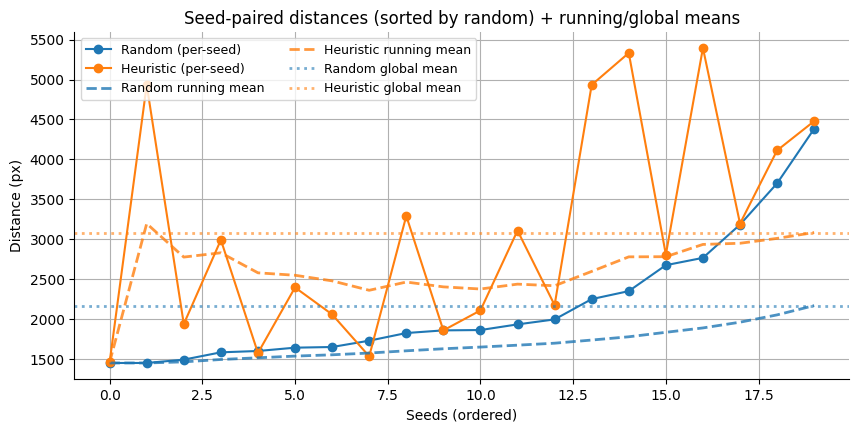

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Helper to make compact boxplots
def boxplot_two(ax, a, b, labels=("Random","Heuristic"), title=""):
    a = pd.to_numeric(a, errors="coerce").dropna()
    b = pd.to_numeric(b, errors="coerce").dropna()
    ax.boxplot([a, b], labels=labels, showfliers=False)
    ax.set_title(title)

# 1) Boxplots: (all rows available)
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))
boxplot_two(axes[0], rnd["distance_px"], heu["distance_px"], title="Distance (px)")
boxplot_two(axes[1], rnd["episode_len_s"], heu["episode_len_s"], title="Episode length (s)")
plt.show()

print("Medians (all rows):")
print("  Random   distance:", np.nanmedian(pd.to_numeric(rnd["distance_px"], errors="coerce")))
print("  Heuristic distance:", np.nanmedian(pd.to_numeric(heu["distance_px"], errors="coerce")))
print("  Random   length(s):", np.nanmedian(pd.to_numeric(rnd["episode_len_s"], errors="coerce")))
print("  Heuristic length(s):", np.nanmedian(pd.to_numeric(heu["episode_len_s"], errors="coerce")))

# 2) Seed-paired line plot (distances)
if len(paired) > 0:
    fig, ax = plt.subplots(figsize=(10, 4.5))
    order = paired.sort_values("distance_random").index.tolist()
    x = np.arange(len(order))

    r_vals = paired.loc[order, "distance_random"].to_numpy(dtype=float)
    h_vals = paired.loc[order, "distance_heuristic"].to_numpy(dtype=float)

    # Per-seed lines (as before)
    l1, = ax.plot(x, r_vals, marker="o", linestyle="-", label="Random (per-seed)")
    l2, = ax.plot(x, h_vals, marker="o", linestyle="-", label="Heuristic (per-seed)")

    # Running (cumulative) mean
    r_run = np.cumsum(r_vals) / (np.arange(len(r_vals)) + 1)
    h_run = np.cumsum(h_vals) / (np.arange(len(h_vals)) + 1)
    ax.plot(x, r_run, linestyle="--", linewidth=2, color=l1.get_color(), alpha=0.8, label="Random running mean")
    ax.plot(x, h_run, linestyle="--", linewidth=2, color=l2.get_color(), alpha=0.8, label="Heuristic running mean")

    # Global mean (horizontal)
    ax.axhline(r_vals.mean(), color=l1.get_color(), linestyle=":", linewidth=2, alpha=0.6, label="Random global mean")
    ax.axhline(h_vals.mean(), color=l2.get_color(), linestyle=":", linewidth=2, alpha=0.6, label="Heuristic global mean")

    ax.set_title("Seed-paired distances (sorted by random) + running/global means")
    ax.set_xlabel("Seeds (ordered)")
    ax.set_ylabel("Distance (px)")
    ax.legend(ncol=2, fontsize=9)
    plt.show()
else:
    print("No paired seeds found; run both policies on overlapping seeds to enable this plot.")


## Part 5 — Death causes (what ends episodes and how often)

**What we’re comparing.**  
For each policy we break down **how episodes end**:
- `spike` — collision with a spike  
- `oob` — out-of-bounds (fell/rised off-screen)  
- `truncated` — time limit reached (no death)  
- `none` — ended without a recorded cause (should be rare; usually indicates manual stop or legacy logs)

**Why this matters.**  
Different policies can fail in different ways. If the heuristic reduces **spike** deaths but increases **oob**, that hints at what the policy sees and where it still struggles.

**What we’ll plot.**  
- A **stacked bar (percentage)** per policy, showing the mix of end causes.  
- A small **counts table** for reference.


Episode end counts by policy/cause:


cause,spike,oob
policy_name,,
heuristic,8,12
random,17,3


Episode end percentages by policy/cause:


cause,spike,oob
policy_name,,
heuristic,40.0,60.0
random,85.0,15.0


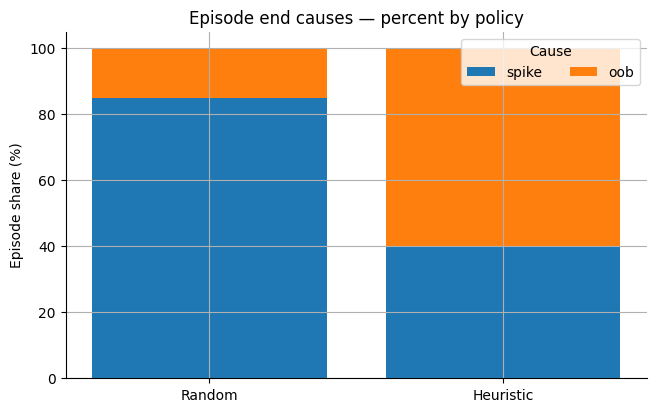

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Build a robust "cause" column
cause = df.get("death_cause", pd.Series([""] * len(df))).fillna("").astype(str)
cause = np.where(df.get("truncated", 0).astype(int) == 1, "truncated", cause)
cause = np.where((df.get("terminated", 0).astype(int) == 0) & (df.get("truncated", 0).astype(int) == 0), "none", cause)
df_causes = df.assign(cause=cause)

# Order categories (include only those present)
all_causes = ["spike", "oob", "truncated", "none"]
present = [c for c in all_causes if c in set(df_causes["cause"].unique())]

# Counts and percentages by policy
counts = (df_causes
          .groupby(["policy_name","cause"])
          .size()
          .reset_index(name="count"))
totals = counts.groupby("policy_name")["count"].transform("sum")
counts["pct"] = counts["count"] / totals

# Pivot into a policy x cause table for display
pivot_counts = counts.pivot(index="policy_name", columns="cause", values="count").fillna(0).astype(int)
pivot_pct = counts.pivot(index="policy_name", columns="cause", values="pct").fillna(0.0)

print("Episode end counts by policy/cause:")
display(pivot_counts.loc[:, present])

print("Episode end percentages by policy/cause:")
display((100 * pivot_pct.loc[:, present]).round(1))

# Stacked percentage bars
fig, ax = plt.subplots(figsize=(7.5, 4.5))
policies = ["random", "heuristic"]
x = np.arange(len(policies))
bottom = np.zeros(len(policies), dtype=float)

for c in present:
    vals = np.array([pivot_pct.loc[p, c] if (p in pivot_pct.index and c in pivot_pct.columns) else 0.0 for p in policies])
    ax.bar(x, vals * 100.0, bottom=bottom * 100.0, label=c)
    bottom += vals

ax.set_xticks(x)
ax.set_xticklabels([p.capitalize() for p in policies])
ax.set_ylabel("Episode share (%)")
ax.set_title("Episode end causes — percent by policy")
ax.legend(title="Cause", ncol=2)
plt.show()


## Part 6 — Grounded ratio (behavioral proxy)

**What we’re comparing.**  
The **grounded ratio** is the share of decision steps where the agent is in firm contact with a platform (vs being mid-air). It’s not a “score,” but a proxy for how each policy moves.

**Why it matters.**  
- A policy that panics may hop/flip frequently → **lower** grounded ratio.  
- A conservative policy may ride platforms longer → **higher** grounded ratio.  
- Comparing distributions helps reveal consistent behavior differences.

**What we’ll plot.**  
- **Boxplots** by policy.  
- **Histograms** side-by-side to compare shapes.


C:\Users\Mbaka\AppData\Local\Temp\ipykernel_7480\4255797012.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([rnd_gr, heu_gr], labels=["Random","Heuristic"], showfliers=False)


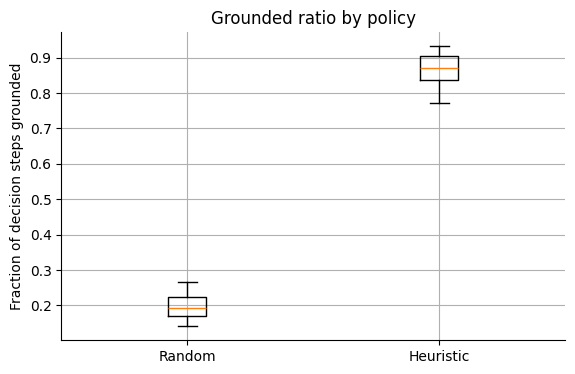

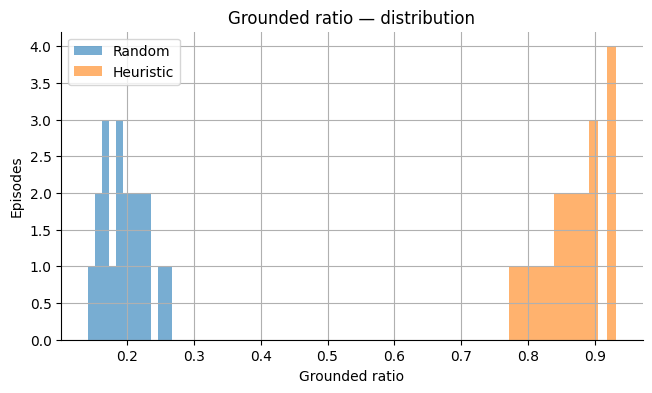

Summary stats:
Random   grounded_ratio: count    20.000000
mean      0.196800
std       0.032353
min       0.141000
25%       0.170000
50%       0.192000
75%       0.222500
max       0.267000

Heuristic grounded_ratio: count    20.00000
mean      0.86740
std       0.04619
min       0.77200
25%       0.83650
50%       0.87050
75%       0.90325
max       0.93200


In [15]:
import matplotlib.pyplot as plt
import numpy as np

if "grounded_ratio" not in df.columns:
    print("No grounded_ratio column found in logs.")
else:
    rnd_gr = pd.to_numeric(df[df["policy_name"]=="random"]["grounded_ratio"], errors="coerce").dropna()
    heu_gr = pd.to_numeric(df[df["policy_name"]=="heuristic"]["grounded_ratio"], errors="coerce").dropna()

    # Boxplot
    fig, ax = plt.subplots(figsize=(6.5, 4))
    ax.boxplot([rnd_gr, heu_gr], labels=["Random","Heuristic"], showfliers=False)
    ax.set_title("Grounded ratio by policy")
    ax.set_ylabel("Fraction of decision steps grounded")
    plt.show()

    # Overlaid histograms
    fig, ax = plt.subplots(figsize=(7.5, 4))
    ax.hist(rnd_gr, bins=12, alpha=0.6, label="Random")
    ax.hist(heu_gr, bins=12, alpha=0.6, label="Heuristic")
    ax.set_title("Grounded ratio — distribution")
    ax.set_xlabel("Grounded ratio")
    ax.set_ylabel("Episodes")
    ax.legend()
    plt.show()

    print("Summary stats:")
    print("Random   grounded_ratio:", rnd_gr.describe().to_string())
    print("\nHeuristic grounded_ratio:", heu_gr.describe().to_string())
